# Sensitivity Analysis for RL Control Policies

### Imports

In [35]:
# imports
import os
import torch

# local imports
from utils import (
    rollout2trajectory,
    subsample,
    compute_state_statistics,
    compute_dense_samples,
    compute_eigenbasis_samples,
    compute_jacobian,
    compute_hessian,
    compute_sensitivity,
    compute_multistep_sensitivity,
    compute_batch_multistep_sensitivity,
    compute_perturbation_error,
    compute_batch_perturbation_error,
    compute_projection_distances,
    compute_subspace_alignment,
    compute_subspace_similarity,
    compute_linearization,
    plot_matrix,
    plot_heatmap,
    plot_1d,
    plot_2d,
    plot_multistep_sensitivity,
    plot_perturbation_error,
    plot_projection_distances,
    plot_subspace_alignment,
)

In [36]:
# load policy
export_dir = "../artifacts/point_mass/2025-11-27_12-15-37"
policy_path = os.path.join(export_dir, "policy_jit.pt")
critic_path = os.path.join(export_dir, "critic_jit.pt")
rollout_path = os.path.join(export_dir, "rollout.pt")
limits_path = os.path.join(export_dir, "policy_limits.pt")
io_path = os.path.join(export_dir, "policy_io.txt")
policy = torch.jit.load(policy_path).eval()
critic = torch.jit.load(critic_path).eval()
rollout = torch.load(rollout_path)
# limits = torch.load(limits_path, map_location=torch.device("cpu"))
with open(io_path, "r") as f:
    print(f.read())
data = rollout2trajectory(rollout)
rollout_obs, rollout_actions, rollout_dones, rollout_critic_obs, rollout_values = data
print(f"Rollout Data: {rollout_obs.numpy().shape}")

<ActionManager> contains 1 active terms.
+----------------------------------+
|  Active Action Terms (shape: 2)  |
+-------+--------------+-----------+
| Index | Name         | Dimension |
+-------+--------------+-----------+
|   0   | joint_effort |         2 |
+-------+--------------+-----------+

<ObservationManager> contains 1 groups.
+---------------------------------------------------+
| Active Observation Terms in Group: 'policy' (shape: (4,)) |
+--------------+---------------------+--------------+
|    Index     | Name                |    Shape     |
+--------------+---------------------+--------------+
|      0       | pose                |     (2,)     |
|      1       | velocity            |     (2,)     |
+--------------+---------------------+--------------+

Rollout Data: (100, 8192, 4)


### Sensitivity Matrix

#### Jacobian

Let $J(x)=\nabla_x \bar u(x) \in \mathbb{R}^{|u|\times|x|}$ be the gradient of the mean control action with respect to the observation with $\bar u(x) = \mathbb{E}\left [\pi(u|x) \right ]$. This Jacobian represents how much the control action changes given a change in the observed state.

#### Local Sensitivity
$$C(x) = J(x)^T J(x)\in \mathbb{R}^{|x|\times|x|}$$

#### Global Approximation of Sensitivity
$$\hat C = \mathbb{E}_{x\sim p_\tau}\left [ J(x)^T J(x) \right ]$$

Let $x_0 \sim \rho(x_0)$ be a uniform prior. Then the marginal visitation distribution induced by $\rho(x_0)$ is given by 

$$p(x_t) = \rho(x_0)\prod^{t-1}_{k=0}T(x_{k+1}|x_k,u_k)\pi(u_k|x_k)$$

with stochastic state transition density $T$ and controller $\pi$. We define the liklihood over the trajectory as 

$$p_\tau(x_0,...,x_t) := \int_{k=0}^{t} p(x_k)dx_k.$$

In practice, we do not have an analytic form for the state transition density and so perform Monte Carlo sampling. Given $N$ rollouts over horizon length $T$ we collect trajectories $\tau=\{(x_0,u_0),(x_1,u_1),...,(x_T,u_T) \}$ with control actions sampled as $u_k\sim\pi(u_k|x_k)$. We then form an approximate state distribution such that $|X_\text{rollout}| = T * N$.

Expanding the expected value yields

$$\hat C = \int_{X_\text{rollout}} p_\tau(x) J(x)^T J(x) dx \approx \frac{1}{|X_\text{rollout}|}\sum_{X_\text{rollout}} J(x)^T J(x)$$

approximated via Monte Carlo. Practically, to prevent overflow for very large samples sizes, the sensitivity can be found iteratively via partial sums for $k=\{0,1,...,|X_\text{rollout}|\}$

$$C(x_k) = J(x_k)^TJ(x_k) \qquad \hat C_0 = C(x_0)$$
$$\hat C_{k+1} = \hat C_k + \frac{1}{k+1}(C(x_{k+1}) - \hat C_k)$$

#### Spectral Analysis

The eigenvalues and eigenvectors of the sensitivity matrix are given by

$$Cv=\lambda v.$$

The direction of worst-case sensitivity is given by the eigenvector $v$ corresponding to the largest eigenvalue $\lambda_\text{max}$.

#### Design Considerations

Consider a policy $\pi_\theta$ paramterized by $\theta$ trained to minimize the PPO loss $\mathcal{L}(\theta) = \mathcal{L}_\text{PPO}(\theta)$. This loss is often augmented with a mirror loss term to encourage symmetric outputs when acted on state symmetry group $L_g[x]$ and action symmetry group $K_g[\pi_\theta(x)]$. Then the PPO objective with mirror loss over symmetry space $\mathcal{G}$ is given by 

$$\mathcal{L}(\theta) = \mathcal{L}_\text{PPO}(\theta) + w\sum_{g\in\mathcal{G}}\mathcal{L}^g_\text{sym}(\theta)$$

with

$$\mathcal{L}^g_\text{sym}(\theta)=\mathbb{E}_{x\sim p_\tau(\theta)}\left[\sum^\infty_{t=0}||K_g[\pi_\theta(x_t)]-\pi_\theta(L_g[x_t])||^2_2 \right].$$

This objective can be additionally augmented with a symmetric state gradient penalty over the sensitivity

$$\mathcal{L}(\theta) = \mathcal{L}_\text{PPO}(\theta) + w\sum_{g\in\mathcal{G}}(1+\nabla_x)\mathcal{L}^g_\text{sym}(\theta)$$

with

$$\nabla_x\mathcal{L}^g_\text{sym}(\theta)=\mathbb{E}_{x\sim p_\tau(\theta)}\left[\sum^\infty_{t=0}||K_g[J_{\pi_\theta}(x_t)x_t]-J_{\pi_\theta}(L_g[x_t])L_g[x_t]||^2_2 \right]$$

or, alternatively,

$$\nabla_x\mathcal{L}^g_\text{sym}(\theta)\approx\mathbb{E}_{x\sim p_\tau(\theta)}\left[\sum^\infty_{t=0}||J_{\pi_\theta}(x_t)^TJ_{\pi_\theta}(x_t)-J_{\pi_\theta}(L_g[x_t])^TJ_{\pi_\theta}(L_g[x_t])||^2_2 \right].$$

Numerically an equivalent quantity can be found by defining $M_g$ which computes the effect of the symmetry group on the sensitivity. Then, the gradient penalty loss can be found via

$$\nabla_x\mathcal{L}^g_\text{sym}(\theta)\approx\mathbb{E}_{x\sim p_\tau(\theta)}\left[\sum^\infty_{t=0}||M_g[C_{\pi_\theta}(x_t)] - C_{\pi_\theta}(L_g[x_t])||^2_2 \right].$$

Note: the above derivation is incorrect due to the omission of the contribution of $\nabla_x p_\tau(x_0,...,x_t)$ from the expected value.

#### Stability Criterion

Consider the nonlinear system $\dot x_t = f(x_t, u_t)$. If we can express $u_t = \pi(x_t)$ then we may express the dynamics as a nonlinear autonomous system $\dot x_t = f(x_t)$. We would like to make the strongest possible claim about the stability and convergence of $f$. We make the following assumptions: $f$ may not be known explicitly but can be sampled efficiently. $\pi$ is a neural network that can be sampled, and we also have access to its Jacobian and Hessian $J(x_t)$ and $H(x_t)$ via autograd. By constructing the sensitivity matrix $C(x_t) = J(x_t)^TJ(x_t)$ and taking its eigenvalues and eigenvectors, we know the worst case perturbation directions (the eigenvectors that correspond to the largest eigenvalues). When $x_t = 0 \in \mathbb{R}^n$ (at the origin), how might we construct a claim about the space of perturbations that the system can recover from e.g. converge back to the origin? Can we make any claim about the speed of convergence? For linear systems, the condition is that the gradient must be negative i.e. $\dot x_t = -Ax_t$ for positive definite $A$. For simple nonlinear systems, upper bounds may be derived. However, we do not assume knowledge of $f$ at this time. If we did know $f$, also provide a sketch of how that information could be used to make a stronger claim about convergence. As a guiding system, consider the double integrator system with action given as accelerations for a unit point mass such that $\dot x_t = [v_{x_t}, \pi(x_t)]$, $x_t = [p_{x_t}, v_{x_t}]$. Do not overfit the solution to this system, as we want to eventually consider the case of legged locomotion where the dynamics are given by the nonlinear manipulator dynamics. Discuss possible strategies and what sort of claims we may be able to make about the system. Provide responses using latex.


Consider the nonlinear system $\dot x_t = f(x_t, u_t)$ for controller $u_t = \pi(x_t)$. Linearize the system about the origin to find the closed loop system Jacobian

$$J_\text{cl} = f_x + f_u J_\pi$$


#### Application

This analysis permits the following applications:

##### sim2real Quantification via Sensitivity

##### Asymmetry Quantification

- By comparing the 

##### The Effects of History Length

- Compute the global input activity for a policy. If elements of the input are inactive over the entire operational domain, then we may conclude that the policy is invariant to the input. Retrain the policy without the inactive input dimensions and compare performance metrics.


- quantify symmetry
- quantify sim2real? function of sensitivity (train with and without DR for a given obs and see difference in sensitivity)

### Synthetic

In [37]:
n_grid = 100
states_uniform, x, y = compute_dense_samples(rollout_obs, n_grid, mode="point_mass")
# Compute sensitivity for eigenbasis
C_policy_uniform, _, eigvecs_policy_uniform, _, _ = compute_sensitivity(policy, states_uniform)
C_critic_uniform, _, eigvecs_critic_uniform, _, _ = compute_sensitivity(critic, states_uniform)

states_uniform_eig, a, b = compute_eigenbasis_samples(eigvecs_critic_uniform, n_grid)
with torch.no_grad():
    values = critic(states_uniform).flatten()
    values_eig = critic(states_uniform_eig).flatten()

# multi step
eigvals_policy_uniform_traj, eigvecs_policy_uniform_traj = compute_multistep_sensitivity(policy, states_uniform)[1:3]
eigvals_critic_uniform_traj, eigvecs_critic_uniform_traj = compute_multistep_sensitivity(critic, states_uniform)[1:3]

# eigvals_policy_uniform_traj_eig = compute_multistep_sensitivity(policy, states_uniform_eig)[1]
# eigvals_critic_uniform_traj_eig = compute_multistep_sensitivity(critic, states_uniform_eig)[1]

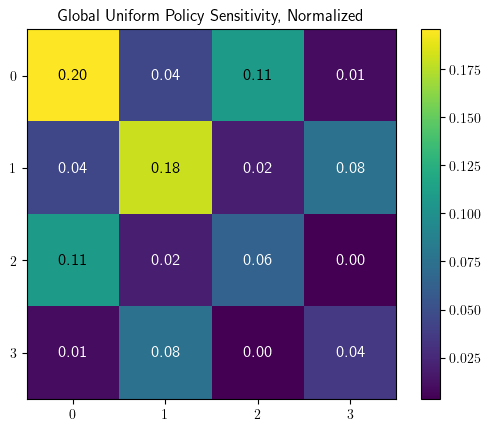

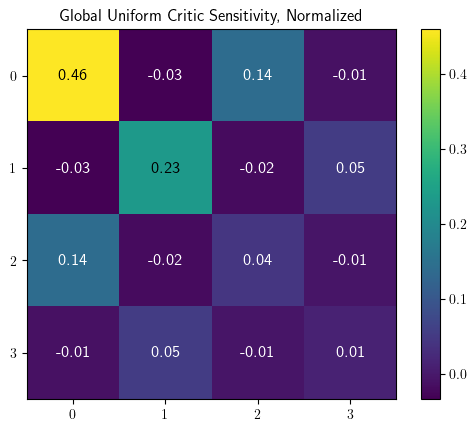

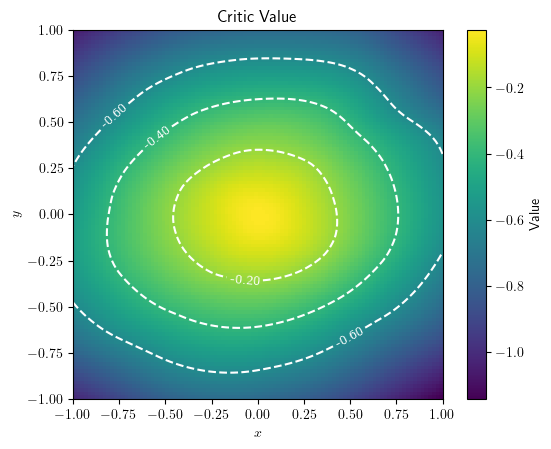

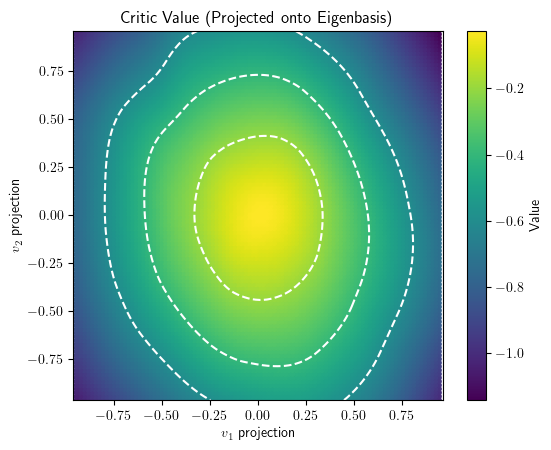

In [38]:
# Critic heatmap
level_sets = [-0.6, -0.4, -0.2]

# Plot 1: Critic Sensitivity Matrix
plot_matrix(C_policy_uniform, "Global Uniform Policy Sensitivity", normalize=True)
plot_matrix(C_critic_uniform, "Global Uniform Critic Sensitivity", normalize=True)

# Plot 2: (x, y) heatmap
plot_heatmap(x, y, values, r"Critic Value", r"$x$", r"$y$", "Value", level_sets)


# Plot 3: eigenbasis sampling heatmap
# plot_heatmap(a, b, values_eig, r"Critic Value Heatmap (Eigenbasis Sampling)", r"$v_1$", r"$v_2$", "Value", level_sets)

# Plot 4: projected states onto eigenbasis
proj = compute_projection_distances(states_uniform, eigvecs_critic_uniform, mean_center=True)
plot_heatmap(proj[:, 0], proj[:, 1], values, r"Critic Value (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Value", level_sets, use_scatter=True)

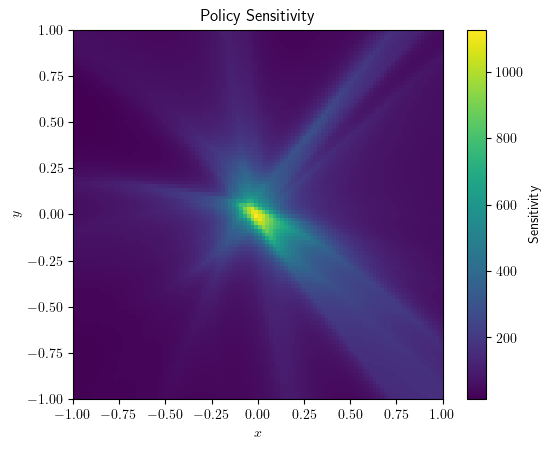

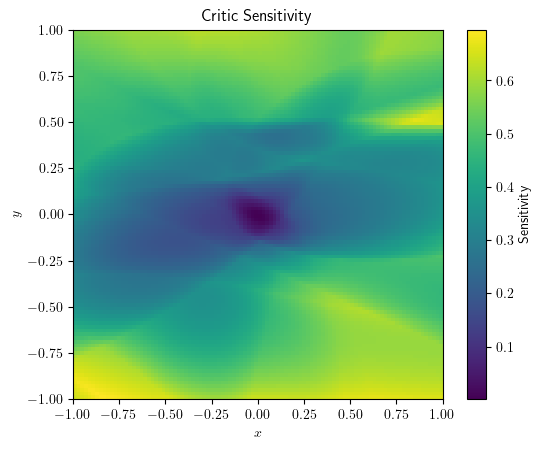

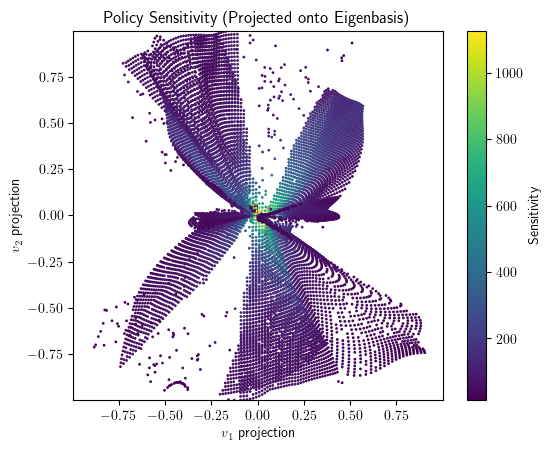

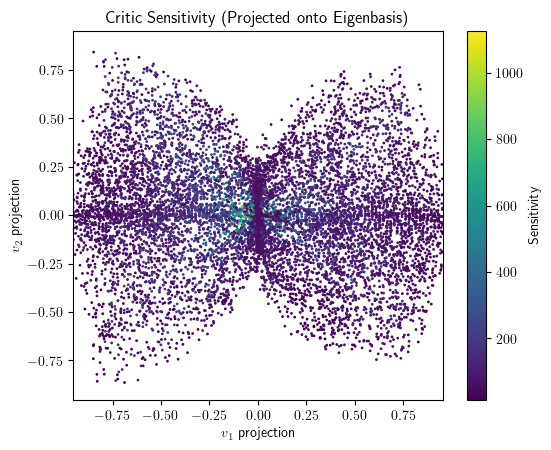

In [39]:
# Sensitivity heatmap
sensitivity_policy = eigvals_policy_uniform_traj.norm(dim=1)
sensitivity_critic = eigvals_critic_uniform_traj.norm(dim=1)
# sensitivity_policy_eig = eigvals_policy_uniform_traj_eig.norm(dim=1)
# sensitivity_critic_eig = eigvals_critic_uniform_traj_eig.norm(dim=1)

proj_policy = compute_projection_distances(states_uniform, eigvecs_policy_uniform_traj, mean_center=True)
proj_critic = compute_projection_distances(states_uniform, eigvecs_critic_uniform_traj, mean_center=True)

plot_heatmap(x, y, sensitivity_policy, r"Policy Sensitivity", r"$x$", r"$y$", "Sensitivity", level_sets=None)
plot_heatmap(x, y, sensitivity_critic, r"Critic Sensitivity", r"$x$", r"$y$", "Sensitivity", level_sets=None)

# plot_heatmap(a, b, sensitivity_policy_eig, r"Policy Sensitivity (Eigenbasis Sampling)", r"$v_1$", r"$v_2$", "Sensitivity", level_sets=None, use_scatter=True, size=10)
# plot_heatmap(a, b, sensitivity_critic_eig, r"Critic Sensitivity (Eigenbasis Sampling)", r"$v_1$", r"$v_2$", "Sensitivity", level_sets=None, use_scatter=True, size=10)

plot_heatmap(proj_policy[:, 0], proj_policy[:, 1], sensitivity_policy, r"Policy Sensitivity (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Sensitivity", level_sets=None, use_scatter=True, size=1)
plot_heatmap(proj_critic[:, 0], proj_critic[:, 1], sensitivity_policy, r"Critic Sensitivity (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Sensitivity", level_sets=None, use_scatter=True, size=1)

### Real

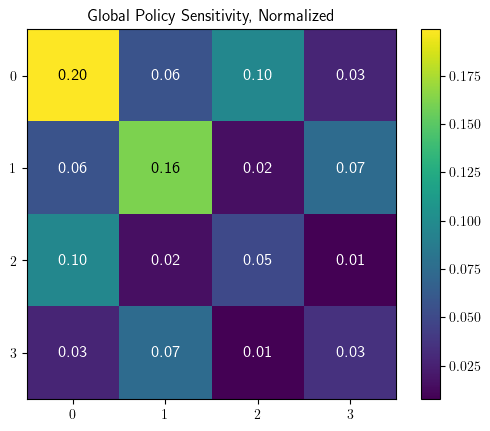

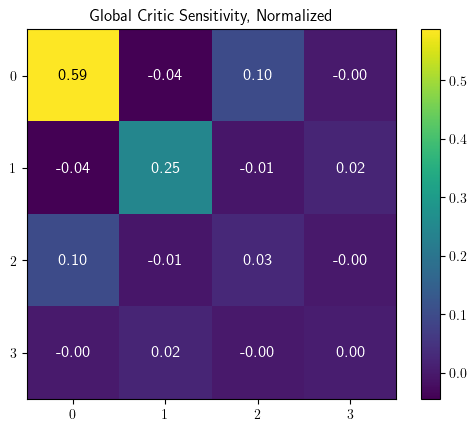

In [40]:
# sensitivity matrix
states = rollout_obs
states_flat = states.reshape(-1, 4)
# compute_state_statistics(states_flat)
C_global, eigvals_global, eigvecs_global, explained_energy_global, input_activity_global = compute_sensitivity(policy, states_flat)
plot_matrix(C_global, "Global Policy Sensitivity", normalize=True)
C_global_critic, _, _, _, _ = compute_sensitivity(critic, states_flat)
plot_matrix(C_global_critic, "Global Critic Sensitivity", normalize=True)

C_traj, eigvals_traj, eigvecs_traj = compute_multistep_sensitivity(policy, states[:, 0])[0:3]

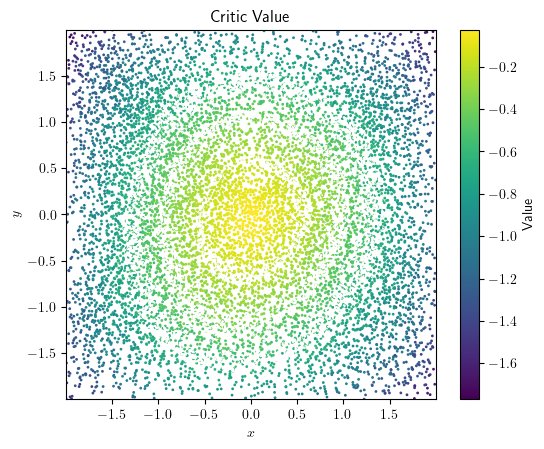

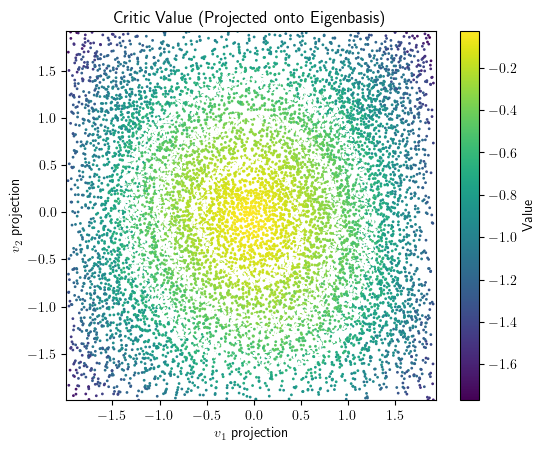

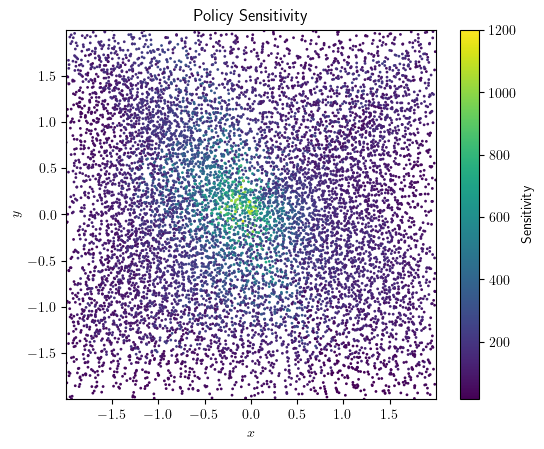

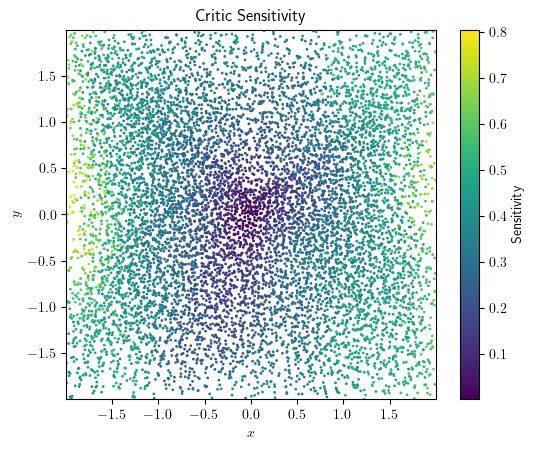

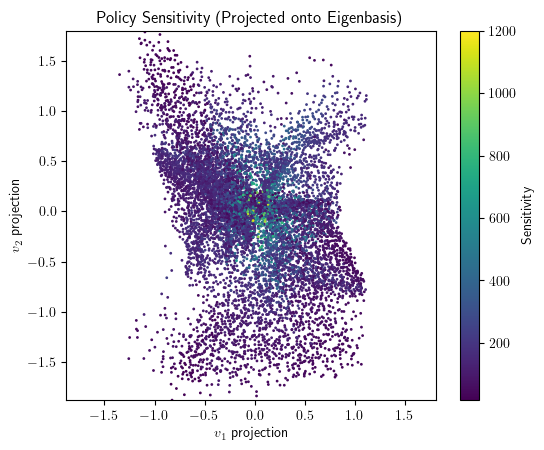

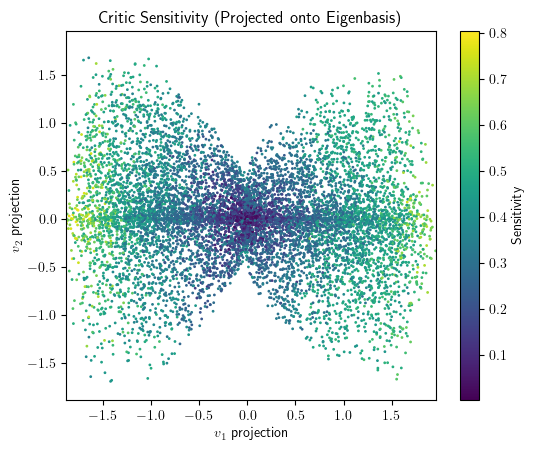

In [48]:
# Heatmaps using real rollout data
states_rollout_full = rollout_obs.reshape(-1, 4)

# Subsampling parameters
n_plot_samples = 10_000  # Number of samples for plotting
subsample_method = "farthest_point"  # "random" or "farthest_point"
min_dist = None  # Alternative: use minimum distance for farthest_point

# Subsample states once upfront
(states_rollout,) = subsample(states_rollout_full, method=subsample_method, n_samples=n_plot_samples, device="cpu")
x_rollout = states_rollout[:, 0]
y_rollout = states_rollout[:, 1]

# Compute sensitivity for eigenbasis on subsampled data
C_critic_rollout, _, eigvecs_critic_rollout, _, _ = compute_sensitivity(critic, states_rollout)

with torch.no_grad():
    values_rollout = critic(states_rollout).flatten()

# Multi-step sensitivity on subsampled data
eigvals_policy_rollout_traj, eigvecs_policy_rollout_traj = compute_multistep_sensitivity(policy, states_rollout)[1:3]
eigvals_critic_rollout_traj, eigvecs_critic_rollout_traj = compute_multistep_sensitivity(critic, states_rollout)[1:3]

sensitivity_policy_rollout = eigvals_policy_rollout_traj.norm(dim=1)
sensitivity_critic_rollout = eigvals_critic_rollout_traj.norm(dim=1)

proj_rollout = compute_projection_distances(states_rollout, eigvecs_critic_rollout, mean_center=True)
proj_policy_rollout = compute_projection_distances(states_rollout, eigvecs_policy_rollout_traj, mean_center=True)
proj_critic_rollout = compute_projection_distances(states_rollout, eigvecs_critic_rollout_traj, mean_center=True)

# Plotting
level_sets_rollout = [-0.6, -0.4, -0.2]

# (x, y) heatmap
plot_heatmap(x_rollout, y_rollout, values_rollout, r"Critic Value", r"$x$", r"$y$", "Value", level_sets_rollout, use_scatter=True, size=1)

# Projected states onto eigenbasis
plot_heatmap(proj_rollout[:, 0], proj_rollout[:, 1], values_rollout, r"Critic Value (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Value", level_sets_rollout, use_scatter=True, size=1)

# Sensitivity heatmaps
plot_heatmap(x_rollout, y_rollout, sensitivity_policy_rollout, r"Policy Sensitivity", r"$x$", r"$y$", "Sensitivity", level_sets=None, use_scatter=True, size=1)
plot_heatmap(x_rollout, y_rollout, sensitivity_critic_rollout, r"Critic Sensitivity", r"$x$", r"$y$", "Sensitivity", level_sets=None, use_scatter=True, size=1)

plot_heatmap(proj_policy_rollout[:, 0], proj_policy_rollout[:, 1], sensitivity_policy_rollout, r"Policy Sensitivity (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Sensitivity", level_sets=None, use_scatter=True, size=1)
plot_heatmap(proj_critic_rollout[:, 0], proj_critic_rollout[:, 1], sensitivity_critic_rollout, r"Critic Sensitivity (Projected onto Eigenbasis)", r"$v_1$ projection", r"$v_2$ projection", "Sensitivity", level_sets=None, use_scatter=True, size=1)

'\nIf Geometric > Spectral:\n    The subspaces align geometrically (the planes overlap), but the order of importance is scrambled. For example, the 1st eigenvector of A aligns with the 5th eigenvector of B. Geometry says "match," but weighting says "mismatch" because the high-energy vector in A is matching a low-energy vector in B.\nIf Spectral > Geometric:\n    This is rarer but happens if the top 1 or 2 vectors match perfectly (dominating the weighted score), while vectors 3 through $k$ are completely orthogonal (dragging down the unweighted average). The eigenvalue-weighted metric is forgiving of errors in the "tail" (low eigenvalues).\n'

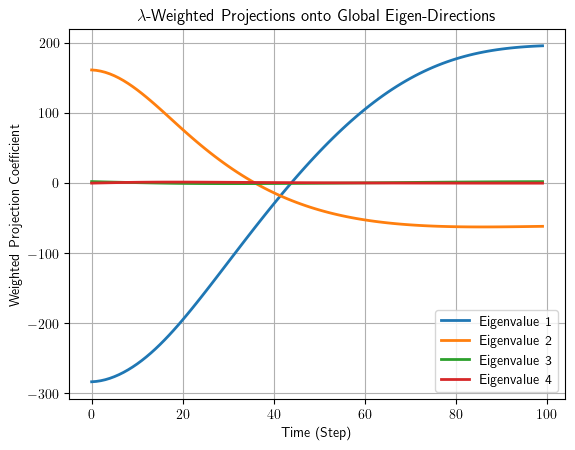

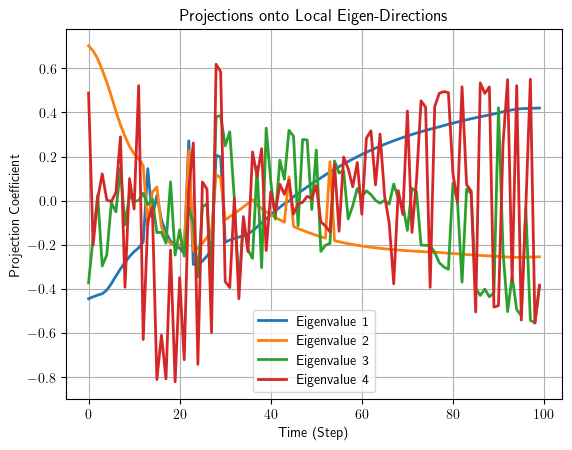

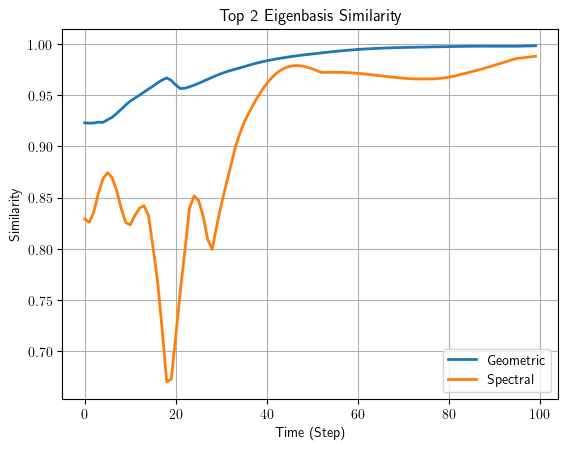

In [42]:
proj_dist_global_dir = compute_projection_distances(states[:, 0], eigvecs_global, mean_center=True)
# plot_2d(proj_dist_global_dir, "Global Eigenbasis Trajectory", r"$v_1$ Basis", r"$v_2$ Basis", temporal=True, linewidth=4)
plot_1d(proj_dist_global_dir * eigvals_global, r"$\lambda$-Weighted Projections onto Global Eigen-Directions", "Time (Step)", "Weighted Projection Coefficient", prefix="Eigenvalue ")

proj_dist_local = compute_projection_distances(states[:, 0], eigvecs_traj, mean_center=True)
plot_1d(proj_dist_local, f"Projections onto Local Eigen-Directions", "Time (Step)", "Projection Coefficient", prefix="Eigenvalue ")

k = 2
geometric_similarity, spectral_similarity = compute_subspace_similarity(eigvecs_global, eigvals_global, eigvecs_traj, eigvals_traj, k=k)
similarity = torch.cat((
    geometric_similarity.unsqueeze(dim=1),
    spectral_similarity.unsqueeze(dim=1),
), dim=1)
plot_1d(similarity, f"Top {k} Eigenbasis Similarity", "Time (Step)", "Similarity", labels=("Geometric", "Spectral"))

"""
If Geometric > Spectral:
    The subspaces align geometrically (the planes overlap), but the order of importance is scrambled. For example, the 1st eigenvector of A aligns with the 5th eigenvector of B. Geometry says "match," but weighting says "mismatch" because the high-energy vector in A is matching a low-energy vector in B.
If Spectral > Geometric:
    This is rarer but happens if the top 1 or 2 vectors match perfectly (dominating the weighted score), while vectors 3 through $k$ are completely orthogonal (dragging down the unweighted average). The eigenvalue-weighted metric is forgiving of errors in the "tail" (low eigenvalues).
"""

### Spectral Analysis
$$Cv=\lambda v$$

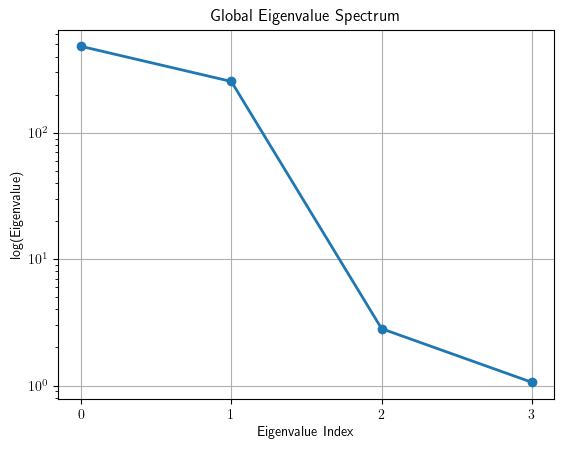

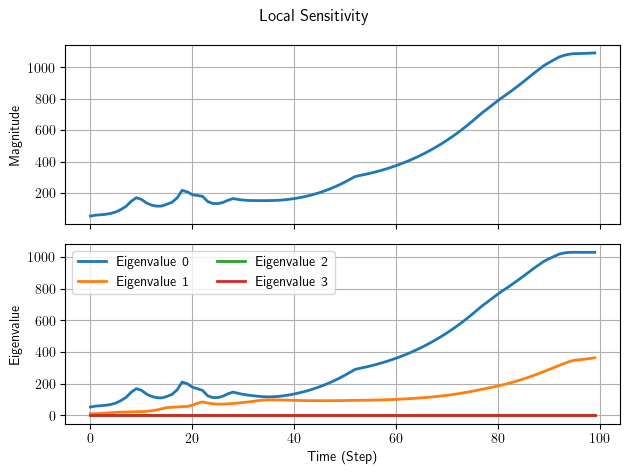

In [43]:
plot_1d(eigvals_global, "Global Eigenvalue Spectrum", "Eigenvalue Index", "log(Eigenvalue)", logy=True, xticks=True, marker="o")
out = compute_batch_multistep_sensitivity(policy, rollout_obs[:, [0]])
C_batch, eigvals_batch, eigvecs_batch, explained_energy_batch, input_activity_batch = out
plot_multistep_sensitivity(C_batch, eigvals_batch, log=False)

### Explained Energy
$$E_i=\frac{\sum_j^i\lambda_j}{\sum\lambda}$$

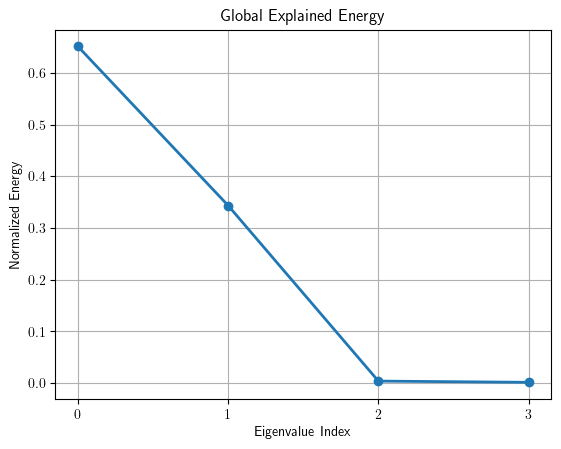

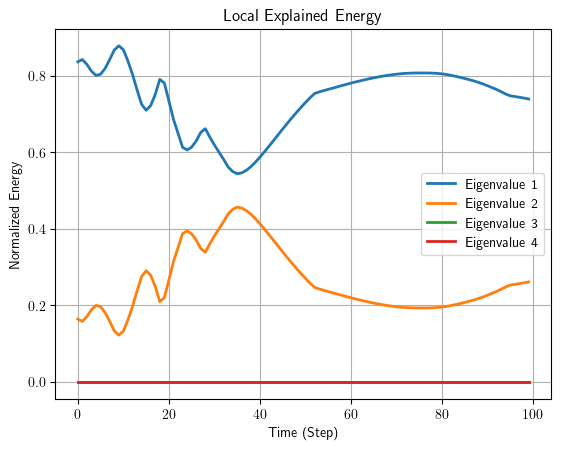

In [44]:
plot_1d(explained_energy_global, "Global Explained Energy", "Eigenvalue Index", "Normalized Energy", marker="o", xticks=True)
plot_1d(explained_energy_batch.squeeze(dim=1), "Local Explained Energy", "Time (Step)", "Normalized Energy", prefix="Eigenvalue ")

### Active Subspace
$$\alpha_i=\sum_j\lambda_jv_{ji}^2$$

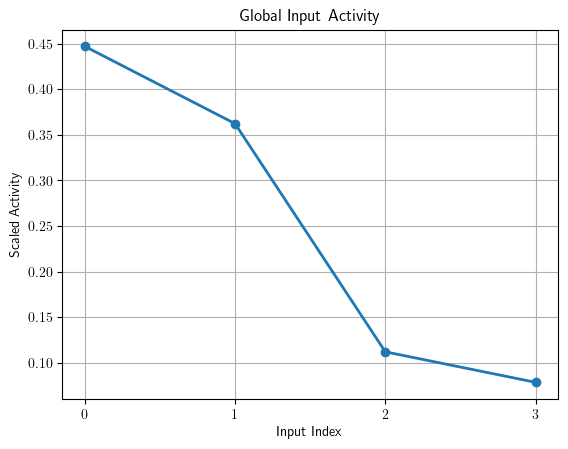

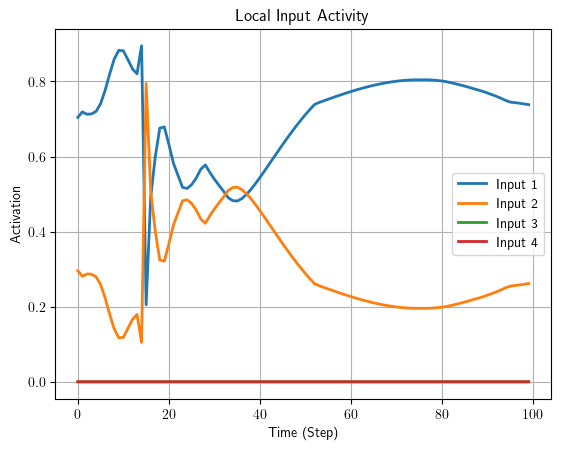

In [45]:
plot_1d(input_activity_global, "Global Input Activity", "Input Index", "Scaled Activity", marker="o", xticks=True)
plot_1d(input_activity_batch.squeeze(dim=1), "Local Input Activity", "Time (Step)", "Activation", prefix="Input ")

### Sensitivity to Perturbation
$$\max_{v}||\pi(x+\alpha v) - \pi(x)|| \approx \alpha||J(x) v||$$

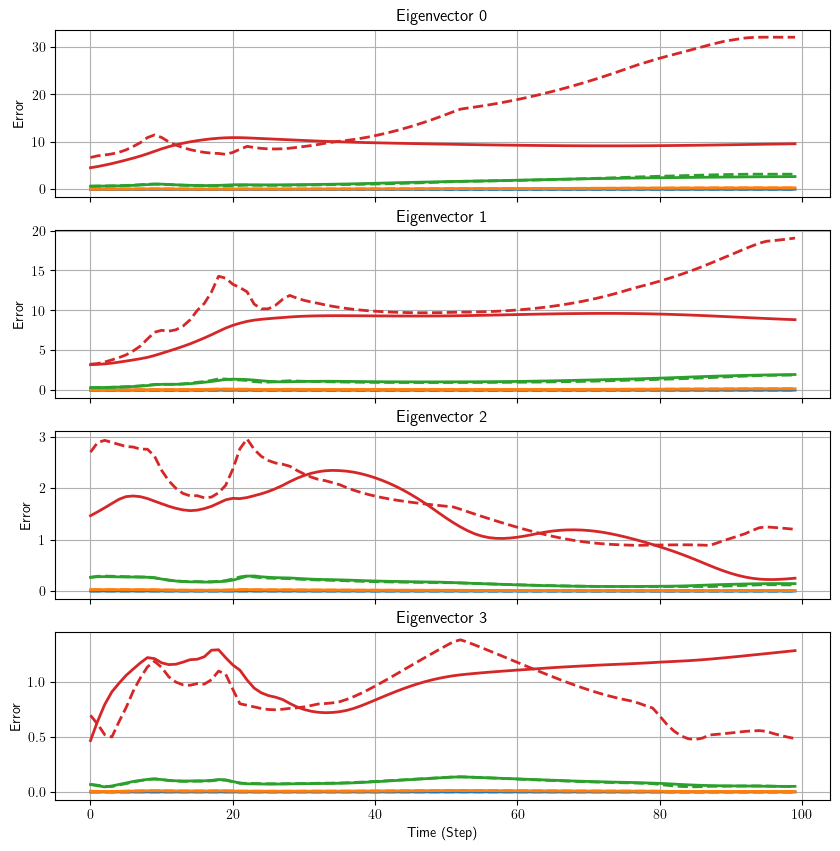

In [46]:
radii = [0.001, 0.01, 0.1, 1.0]
errors, errors_linear = compute_perturbation_error(policy, rollout_obs, eigvecs_global, radii, env_idx=0)
plot_perturbation_error(errors, errors_linear, eigvecs_global, radii, log=False)

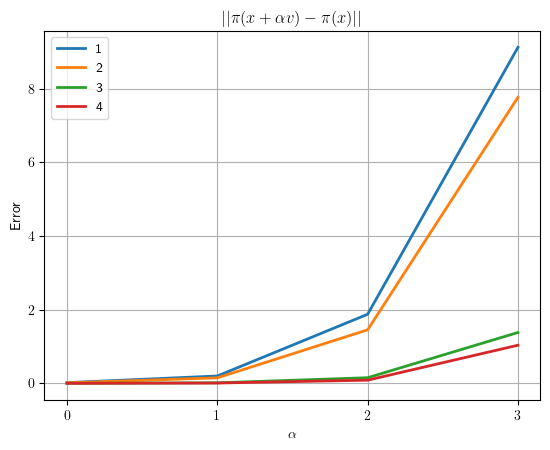

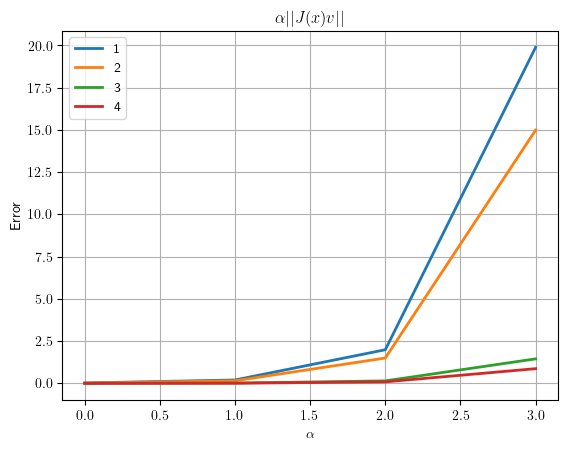

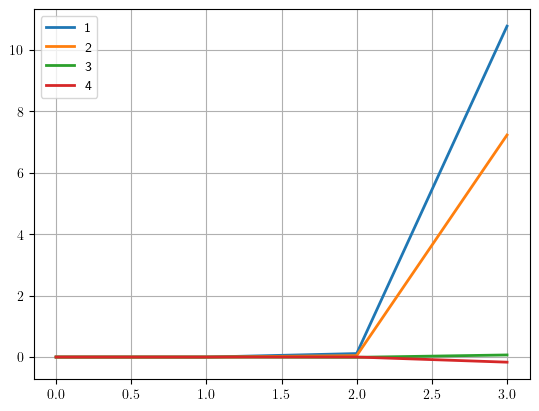

In [47]:
errors, errors_linear = compute_batch_perturbation_error(policy, rollout_obs, eigvecs_global, radii)
plot_1d(errors.T, r"$||\pi(x+\alpha v) - \pi(x)||$", r"$\alpha$", "Error", xticks=True, logx=False)
plot_1d(errors_linear.T, r"$\alpha||J(x)v||$", r"$\alpha$", "Error")
plot_1d(errors_linear.T - errors.T, "", "", "")